1. overview of virtualization
1. main techinical approaches in popular virtualization solutions
1. Virtualization-related hardware advances
1. "Virtual Machine Monitors: Current Technologies and Futreu Trends" by Rosenblum and Garfinkel
    1. great summar y of lesson content
    

### What's vertualization? (at IBM in the 60's)
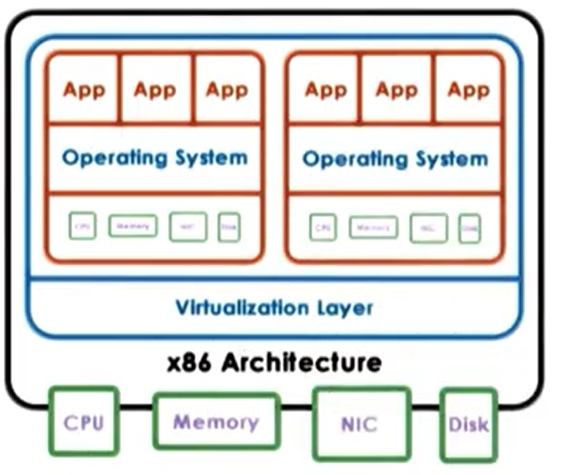
1. Virtualization allows concurrent execution of multiple OSs (and their applications) on the same physical machine
1. Virtual resources == each OS thinks that it "owns" hardware resources
1. Virtual Machine (VM) == OS + application + virtual resources (guest domain)
1. virtualization layer == management of physical hardware (virtual machine monitor, hypervisor)
    1. allocation and management of physical hardware
    1. isolation

### Defining Virtualization
1. a virtual machine is an efficient isolated dupliate of the real machine
1. supported by a virtual machine monitor (VMM): layer where virtual machine exists
    1. fidelity: provides environment essentially identical with the original machine
    1. performance: programs show at worst only minor decrease in speed (with the same resources)
    1. safety & isolation: VMM is in complete control of system resources, has full controls of 
        1. who accesses
        1. which resources
        1. when

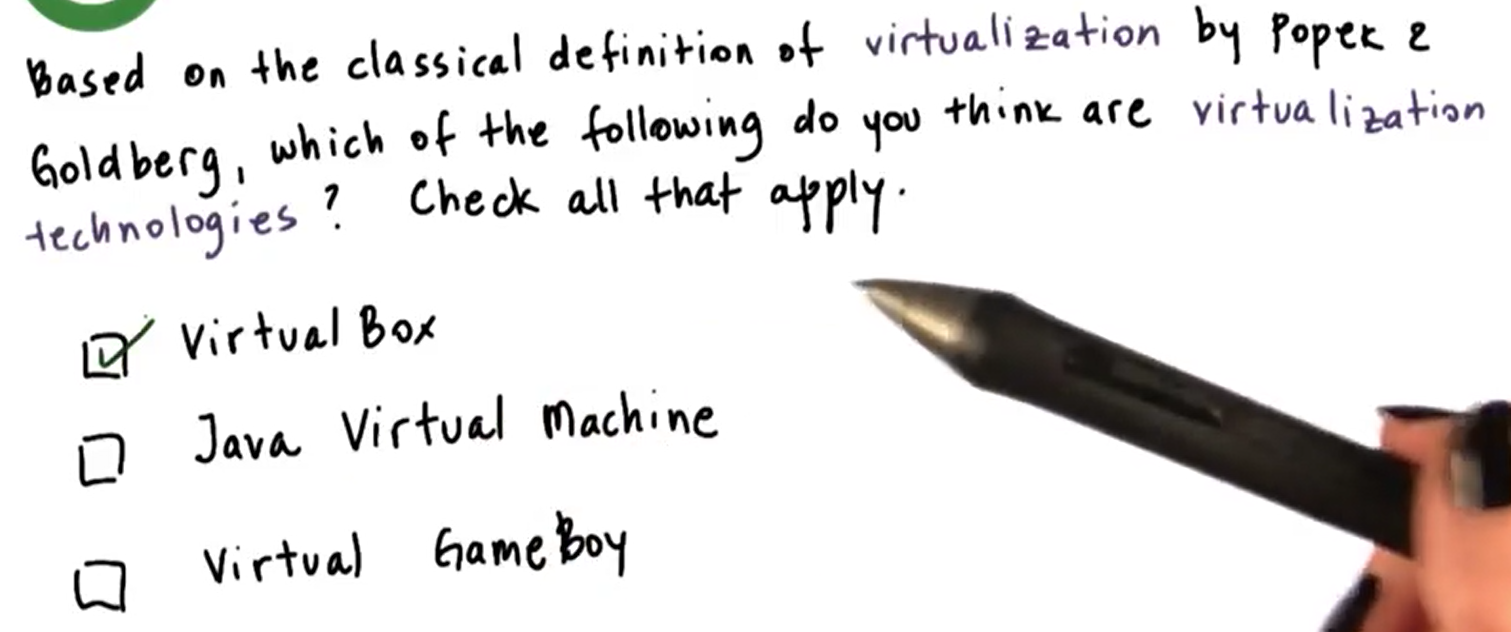

### Why do we care about virtualization
1. consolidation: run multiple virtual machines with their OS and app on a single physical platform
    1. decrease cost, improve manageability
1. migration
    1. avaiabliabity (create multiplay is workload increase), reliability (copy to another machine if the current is down): 
        1. easy to migrate from one physical machine to antoher
        1. copy or clone at the same time
1. security (limit bugs to the resources allocated to the VM)
1. debugging 
1. support for legacy OSs

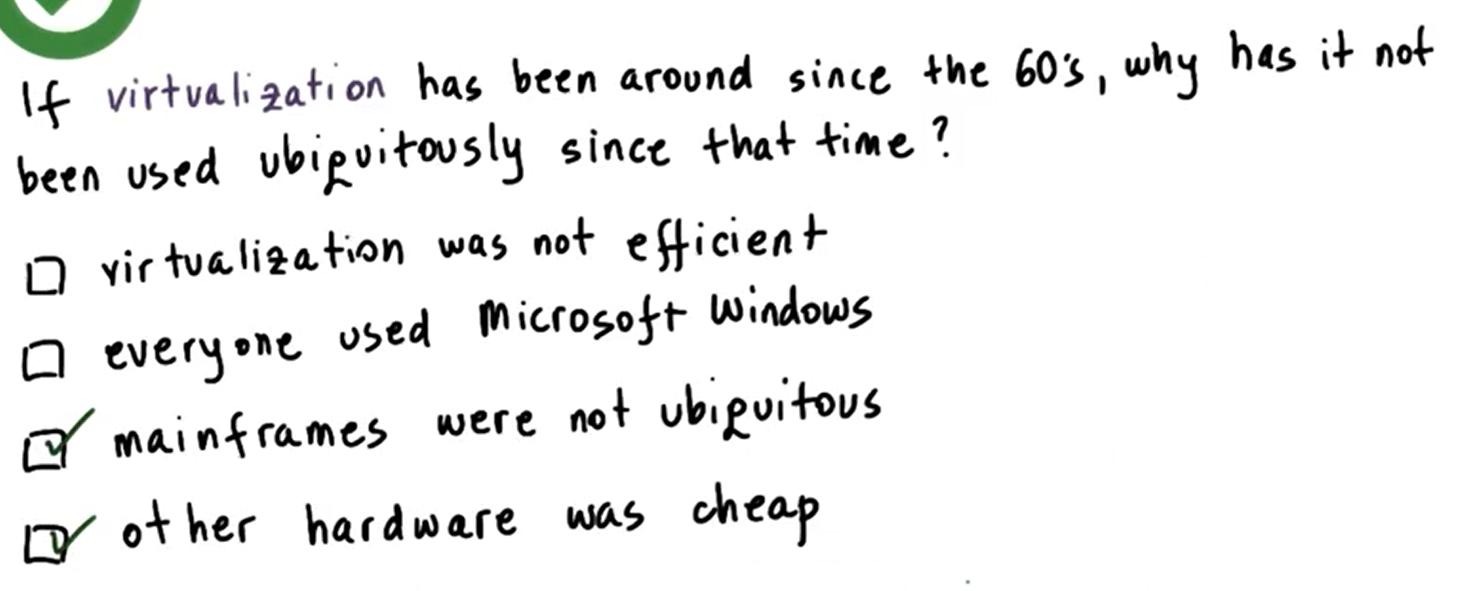

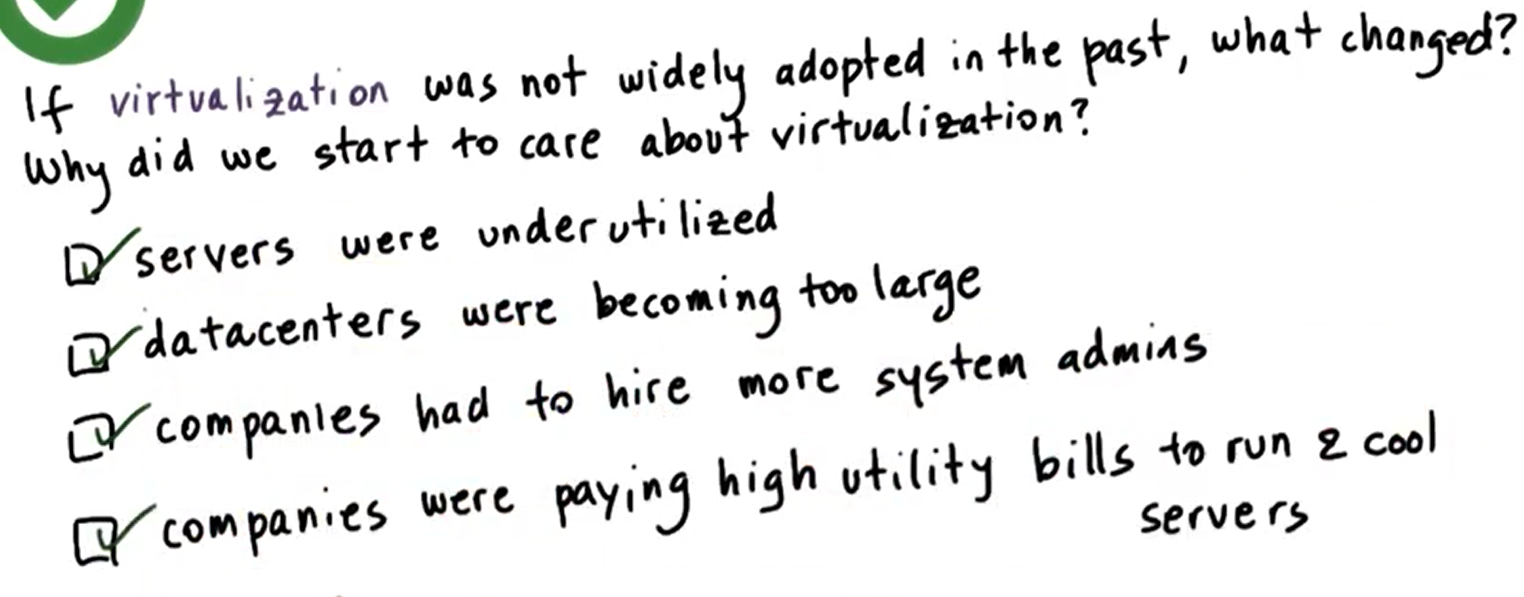

### Two amin virtualization Models
1. Bare-metal or Hypervisor-based (type 1)
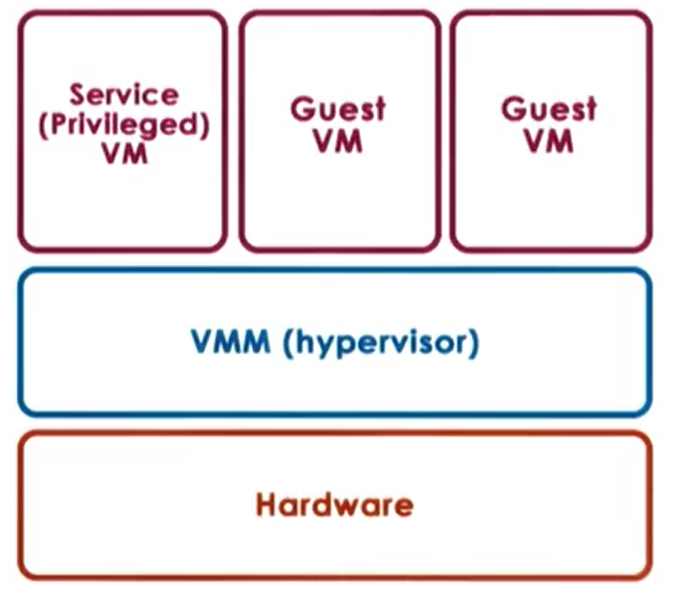
    1. VMM (hyperviser) manages all hardware resources and supports execution of VMs
    1. device need to provide drivers for VMM too
    1. to limit the need for special drivers, VMM integrate special servie VM running standard OS, with full hardware previleged, service VM to deal with devices (and other confiuration and management task)
    1. examples:
        1. Xen (open source or Citrix Xen Server)
            1. dom 0 (specail) and domUs
            1. drivers in dom0
        1. ESX (VMware)
            1. many open APIs 
            1. drivers in VMM
            1. used to have Linux control core, now remote APIs
1. Hosted (type 2)
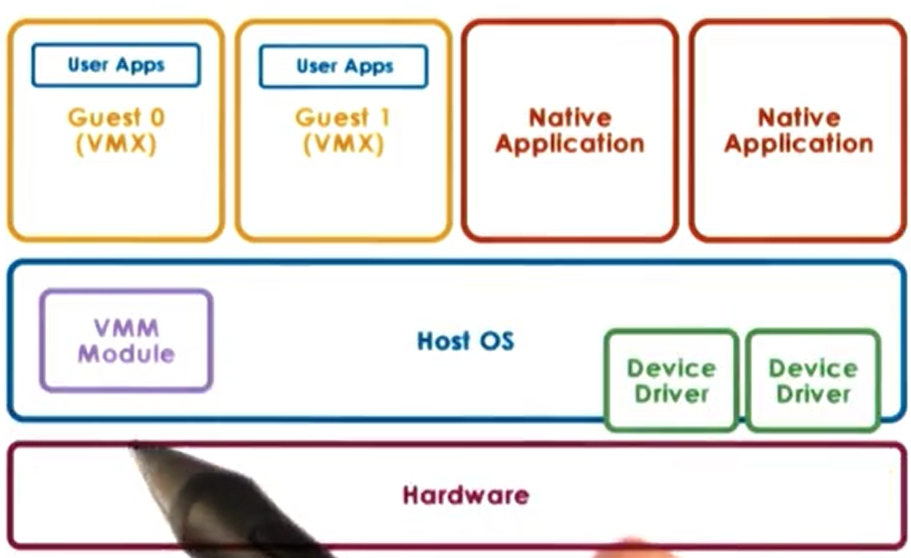
    1. host OS owns all hardware
    1. host OS integrate VMM module
    1. Special VMM module provides hardware interfaces to VMs and deals with VM context switching
    1. it can leverage all mechnism develped for the host OS, much less functionality needed to develop VMM module
    1. native applications can be run on host OS
    1. examples:
        1. KVM (Kernel-based VM)
            1. based on Linux
            1. KVM Kernel module + QEMU(hardware emulator) for hardware virtualization
            1. QEMU provides exactly the same hardware as physical hardware
            1. driver from host OS
            1. leverages linux open-source community
            1. was orignally developed as a Linux module

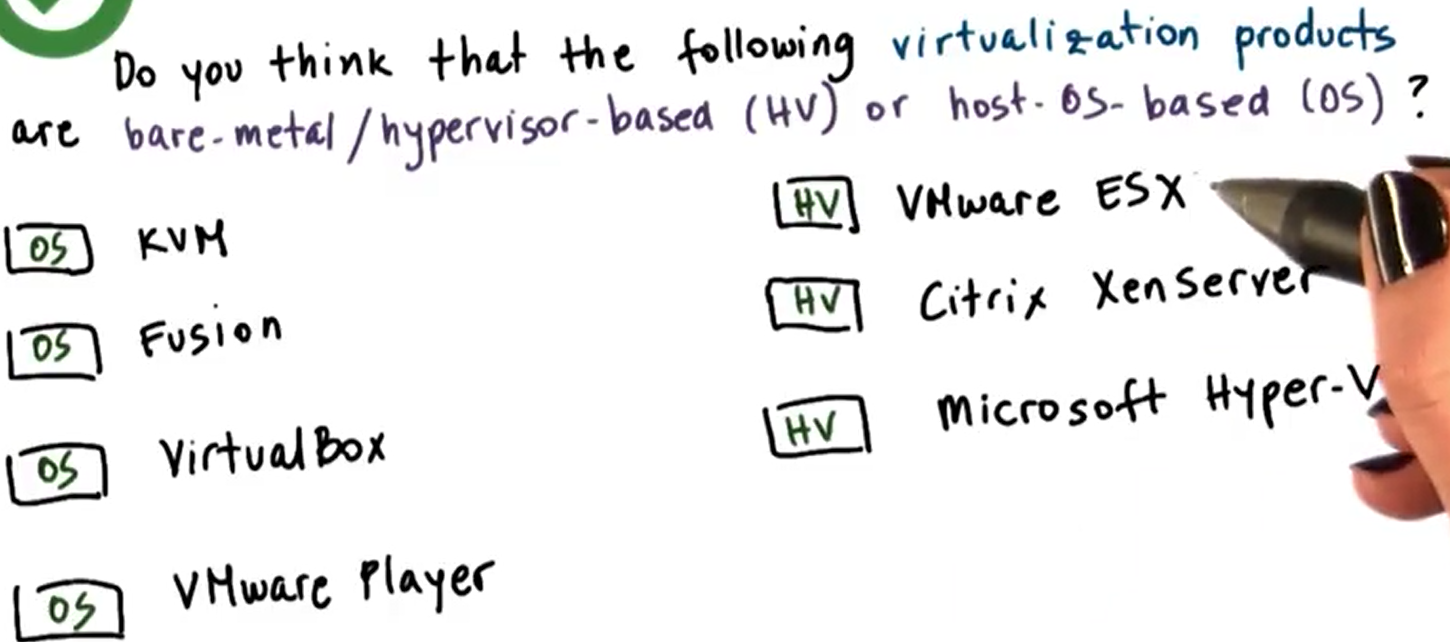

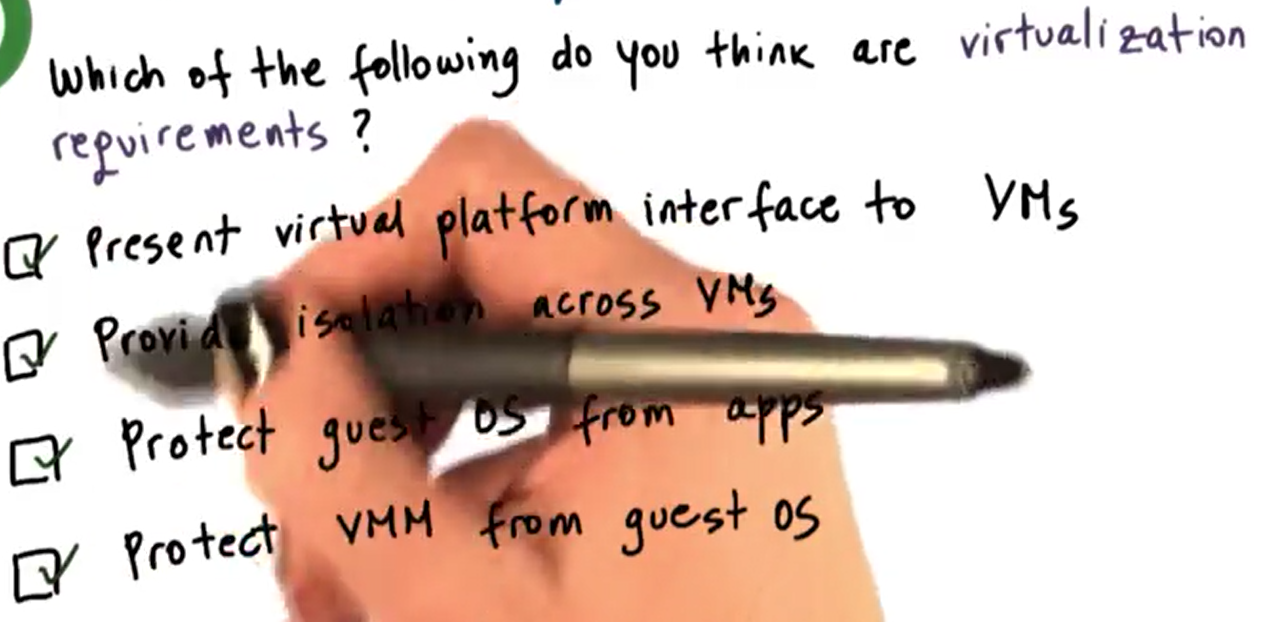

### Hardware Protection Levels
1. commodity hardware has more than 2 protection levels
    1. x86 has 4 protection levels (rings)
        1. ring 3: lowest privilege (apps)
        1. ring 0: highest privilege (os)
    1. for vmm
        1. ring 3: app
        1. ring 1: os
        1. ring 0: hypervisor
    1. modern x86 has 4 protection levels (rings) and 2 protection modes (root & non-root)
        1. non-root: VMs
            1. ring3 : apps
            1. ring0: so
        1. root:
            1. ring0: hypervisor
    1. app temps by the guest OS to perform privileged operations 
        1. cause traps that are called VMexits
        1. trigger a switch to this root mode and pass control to the hypervisor
        1. when hypervisor completes it passes control back to the virtual machine by perform a VMentry which swtich the mode into non-root mode to ring0

### Processor Virtualization (trap-and-emulate)
1. Guest instruction
    1. executed directly by hardware
    1. VMM doesn't interfere with every single instruction
    1. for non-privileged operations: at hardware  sppeds => efficiency (as long as the guest OS operates within the resources allocated to them)
    1. for privileged operations: trap to hypervisor
    1. hypervisor determins what needs to be done:
        1. if illegal operation: terminate VM...
        1. if legal operation: emulate the behavior the guest OS expecting from the hardware

### Problems with trap-and-emulate
1. x86 Pre 2005
    1. 4 rings, no root/non-root modes yet
    1. hypervisor in ring0, guest OS in ring1
    1. 17 privileged instructions do not trap! fail silently 
        1. not allowed if not issued from ring0
        1. don't cause trap
        1. issue from ring1 or above won't pass control to the hyperisor and fail silently
        1. e.g. interrupt enable/disable bit in privileged rigister; POPF/PUSHF instruction that access it from ring1 fail silently, and instruction pipeline is allowed to continue to the next instruction
    1. hypervisor doesn't know, so it doesn't try to change settings
    1. OS doesn't know so assumes change was successful

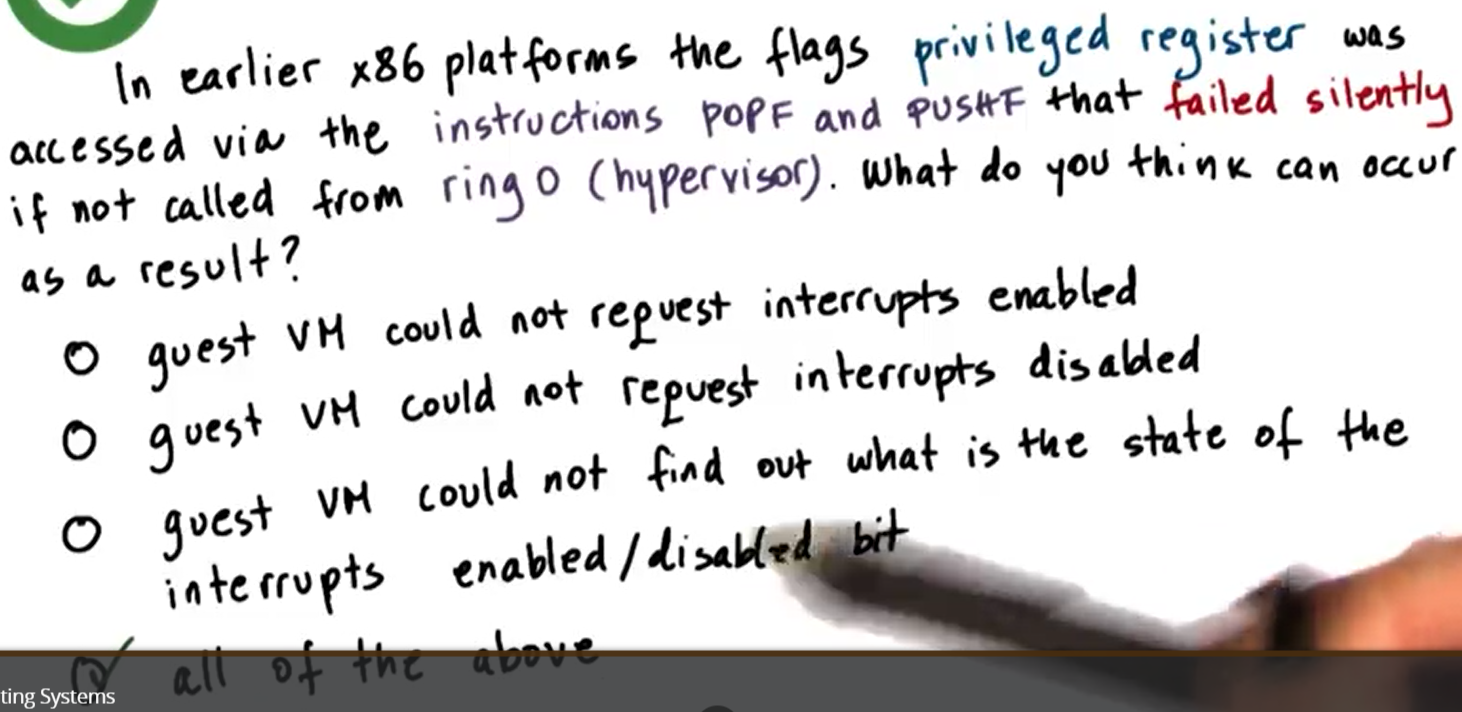

### Binary Translation
1. main idea: rewrite the VM binary to never issue those 17 instructions
1. Pioneered by Mendel Rosenblum's groupo at Standford commercialized as VMware
    1. Rosenblum awared ACM Fellow for "reinventing virtualization"
1. Binary translation:
    1. goal: full virtualization == guest OS not modified
    1. approach: dynamic binary translation
        1. can't be static because the sequence of execution may depend on some parameters
    1. inspect code blocks to be executed
    1. if needed translate to alternative instruction sequence. e.g. to emulate desired behavior, possibly even avoiding trap
    1. if there is none of the 17 instructions, run at hardware speed
    1. speedup:
        1. cache translated blocks to amotize translation costs (translation can be avoided in the future)
        1. which portion of binary should be analyzed (only kernel codes are analyzed) 

### Paravirtualization
1. goal: performance; give up on unmodified guests
1. approach: paravirutalization == modify guest so that...
    1. it knows it's running virtualized
    1. it makes explicit calls to the hypervisor (hypercalls) 
    1. hypercall (~system calls)
        1. package context info
        1. specify desired hypercall
        1. trap to VMM
        1. when finish, control will be passed to the VM, any data will be avaiable to VM
    1. e.g. Xen == open source hypervisor (XenSource -> Citrix)

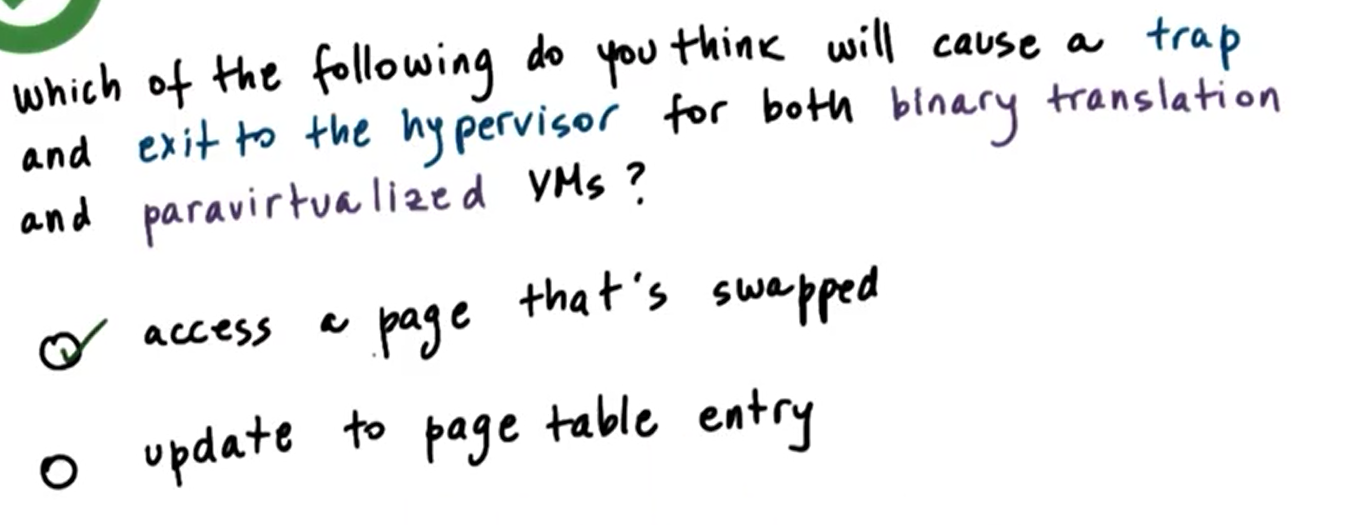

### Memory virtualization
1. Full virtualization
    1. all guests expect contiguous physical memory starting at 0
    1. virtual vs physical vs machine addresses and page frame numbers
        1. virtual address: used by the applciations in the guest
        1. physical address: guest thinks are the addresses of the physical resource
        1. machine addresses: actual machine addresses with the actual phusical addresses on the underlying platform
    1. two page tables (option 1)
        1. guest page table: VA=>PA (maintained by guest OS)
        1. hypervisor: PA=>MA (maintained by hypervisor) (used by MMU)
    1. option 2
        1. guest page table: VA=>PA
        1. hypervisor shadow page table: VA=>MA (used by MMU)
        1. hypervisor maintains consistence
            1. e.g. invalidate on context switch
            1. write protect guest page table (new write causes a trap) to track new mappings...    
    1. still leverages hardware MMU, TLB...
    
    
1. Paravirtualization
    1. guest aware of virtualization
    1. no longer strict requirement on contiguous physical memory starting at 0
    1. explicitly register page tables wit hhypervisor
    1. can batch page table updates to reduce VM exits
    1. ... other optimizations
    1. overheads eliminated or reduced on newer platforms

### Device Virtualization
1. For CPUs and memory
    1. less diversity. ISA-level standardization fo interface
1. for devices:
    1. high diversity
    1. lack of standard specification of device interface and behavior
1. 3 key models for device virtualization (pre-vt hardware)
    1. pasthrough model
        1. Approach: VMM-level driver configures device access permissions
        1. pros: 
            1. VM provided with ecxlusive access the the device 
            1. VM can directly access the device (VMM-bypass)
        1. cons:
            1. device sharing difficult (reassign access to vm, access not simultaneously, very high overhead)
            1. VMM must have exact type of device as what VM expects, so that VM can request the access, but this is not practical
            1. VM migration tricky:
                1. break VM decoupling due to the directly binds a device to a VM 
                1. device spefici state
                1. device resident state need to be copied and migrated and then configurated at the destination mount
                1. truns Vm migration not in a hyperviser and VVM specific operation
                1. specifics of all aprticular devices of interest
    1. Hypervisor-direct model
    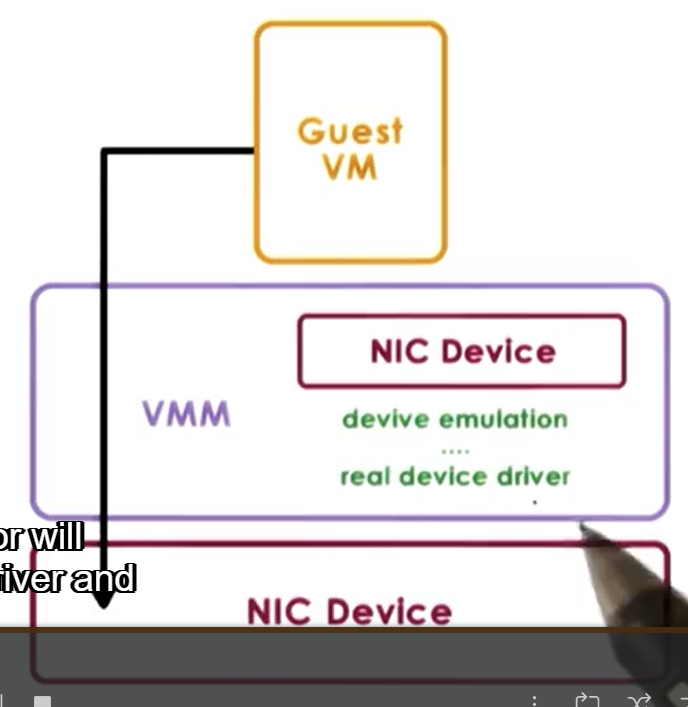
        1. approach:
            1. VMM intercepts all device accesses
            1. emulate device operation:
                1. translate to generic I/O op
                1. traverse VMM-resident I/O stack
                    1. bottom of the stack is the real device driver
                1. invoke VMM-resident driver
        1. pros:
            1. VM decoupled from physical device
            1. sharing migration, dealing with device specifics handled by VMM 
        1. cons:
            1. latency of device operations 
            1. device driver ecosystem complexities in hypervisor
    1. Split-Device Driver model
    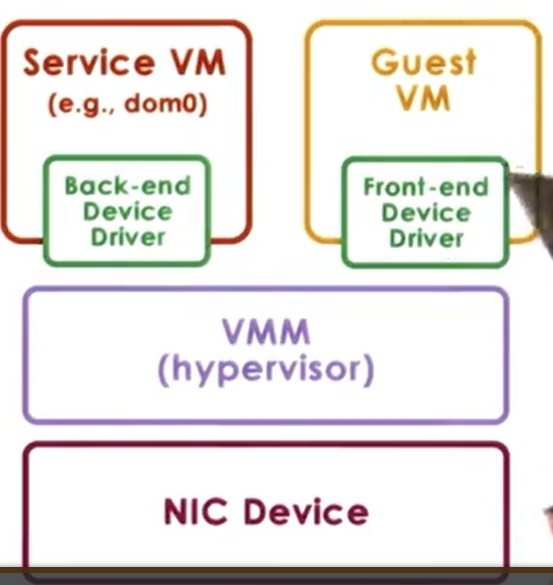
        1. approach
            1. device access control split between front end driver in guest VM (device api, like a wrapper)
            1. back-end driver in service VM (or Host)
            1. modified guest driver
                1. i.e. limited to paravirtualized guests
        1. pros:
            1. eliminate emulation overhead
            1. allow for better management of shared deviced
            

### Key Virtualization - Related Hardware Features - x86
1. AMD Pacifica & Intel Vanderpool Technology (intel-VT) 2005
1. modes: root/non-root (or "host" and "guest" mode)
1. close the hole of 17 non-virtualizable instructions
1. they will cause a trap and pass control over in a privileged mode
1. VM control structure
    1. per VCPU, walked by hardware
    1. it can specify if a system call should be trap or handled by the previleged layer in nont-root mode
1. extended page tables and tagged TLB with VM ids
    1. context switch among VM => world swtich, we don't have to flush or invalidate  the entries in TLB. 
    1. match both address and id
    1. context switch more efficient
1. hardware support better I/O virtualization
    1 modifications both to the processor and the chipset side
1. device and system interconnect capabilities 
    1. multiqueue devices used by different VM
    1. interupt routing, device interrupt the core where VM is executing and not some other CPUs
1. security and management support
1. additional instructions to exeercise the above features
    1. transition between root mode and non-root mode 
    1. manipulate state in the per VM control data structure

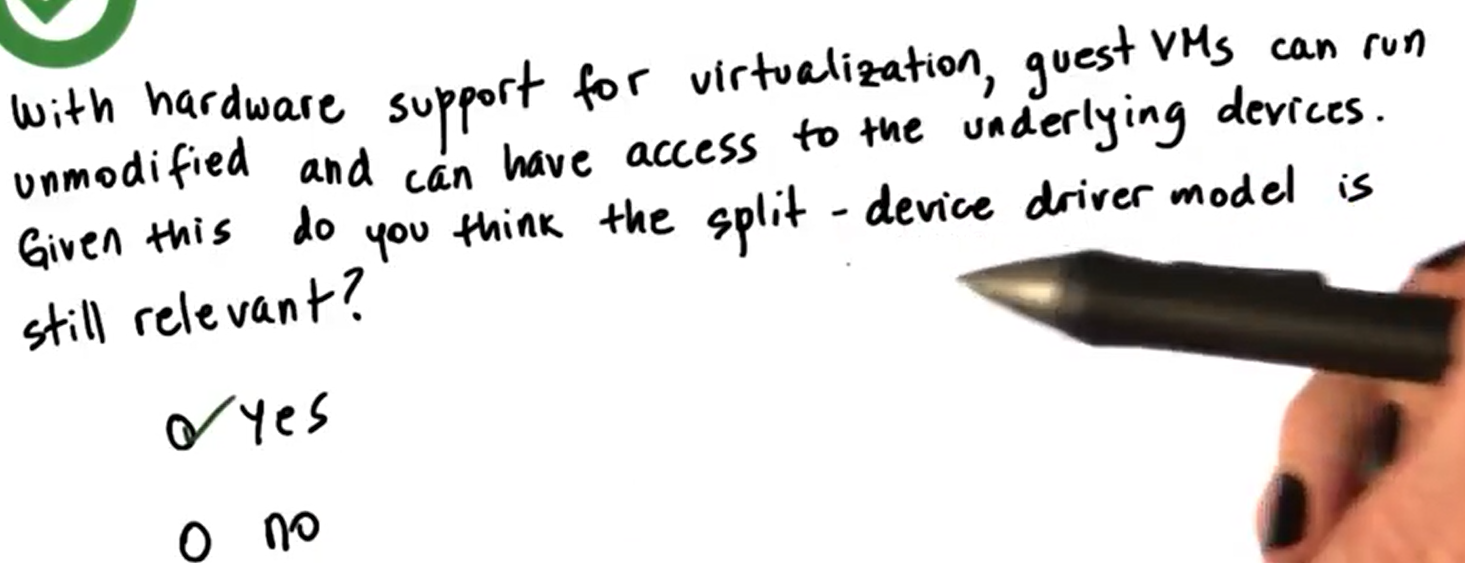
1. we can consolidate all of the request for device access to the surface VM, where we can 
    1. make better decisiosn 
    1. enforce better policies in therms of how the device is shared
    1. without rely to specific suuport for desired behavior on the physical device

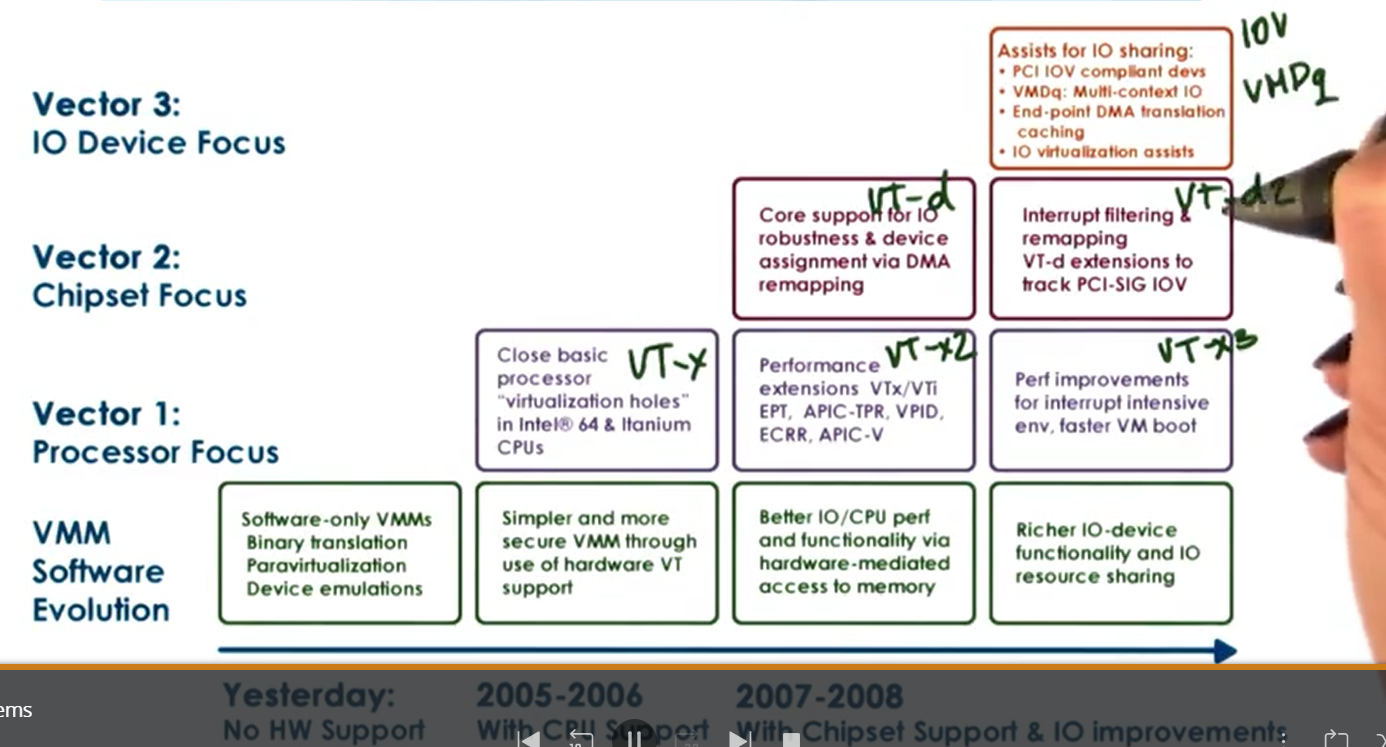